# Get all required data

In [75]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [76]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import sklearn
sklearn.set_config(transform_output="pandas")

In [77]:
# data_path = '/content/data/'
data_path = '/Users/tuan.nt/Documents/kaggle_interval_prediction/data/'
# /Users/tuan.nt/Documents/kaggle_interval_prediction/data
train_data = data_path + 'train.csv'
test_data = data_path + 'test.csv'
sample_sub = data_path + 'sample_submission.csv'
submission = data_path + 'submission.csv'

In [78]:
# Notice that we use absolute values due to the possibility of 'quantile crossing' where lower > upper.

def WIS_and_coverage(y_true,lower,upper,alpha):

    assert np.isnan(y_true) == False, "y_true contains NaN value(s)"
    assert np.isinf(y_true) == False, "y_true contains inf values(s)"
    assert np.isnan(lower)  == False, "lower interval value contains NaN value(s)"
    assert np.isinf(lower)  == False, "lower interval value contains inf values(s)"
    assert np.isnan(upper)  == False, "upper interval value contains NaN value(s)"
    assert np.isinf(upper)  == False, "upper interval value contains inf values(s)"
    assert alpha > 0 and alpha <= 1,  f"alpha should be (0,1]. Found: {alpha}"

    # WIS for one single row
    score = np.abs(upper-lower)
    if y_true < np.minimum(upper,lower):
        score += ((2/alpha) * (np.minimum(upper,lower) - y_true))
    if y_true > np.maximum(upper,lower):
        score += ((2/alpha) * (y_true - np.maximum(upper,lower)))
    # coverage for one single row
    coverage  = 1 # assume is within coverage
    if (y_true < np.minimum(upper,lower)) or (y_true > np.maximum(upper,lower)):
        coverage = 0
    return score, coverage

# vectorize the function
v_WIS_and_coverage = np.vectorize(WIS_and_coverage)

def score(y_true,lower,upper,alpha):
    """
    This is an implementation of the Winkler Interval score (https://otexts.com/fpp3/distaccuracy.html#winkler-score).
    The mean over all of the individual Winkler Interval scores (MWIS) is returned, along with the coverage.

    See:
    [1] Robert L. Winkler "A Decision-Theoretic Approach to Interval Estimation", Journal of the American Statistical Association, vol. 67, pp. 187-191 (1972) (https://doi.org/10.1080/01621459.1972.10481224)
    [2] Tilmann Gneiting and Adrian E Raftery "Strictly Proper Scoring Rules, Prediction, and Estimation", Journal of the American Statistical Association, vol. 102, pp. 359-378 (2007) (https://doi.org/10.1198/016214506000001437) (Section 6.2)

    Version: 1.0.4
    Author:  Carl McBride Ellis
    Date:    2023-12-07
    """

    assert y_true.ndim == 1, "y_true: pandas Series or 1D array expected"
    assert lower.ndim  == 1, "lower: pandas Series or 1D array expected"
    assert upper.ndim  == 1, "upper: pandas Series or 1D array expected"
    assert isinstance(alpha, float) == True, "alpha: float expected"

    WIS_scores, coverage = v_WIS_and_coverage(y_true,lower,upper,alpha)
    MWIS      = np.mean(WIS_scores)
    MWIS      = float(MWIS)
    coverage  = coverage.sum()/coverage.shape[0]
    coverage  = float(coverage)

    return MWIS,coverage

In [79]:
train  = pd.read_csv(train_data, index_col="id")
test = pd.read_csv(test_data, index_col="id")

In [80]:
test.head()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,ILP_R,LD_INDL,MAGER,MBSTATE_REC,MEDUC,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108082,1,1,23.6,0,11,,8,1231,4,26,4,888,888,888,N,27,1,3,61,1,1,1,1,1,1,18,0,0,0,125,3,1,N,0,M,53
108083,1,1,20.1,0,7,1,4,851,5,32,4,25,63,25,N,32,1,5,60,1,1,0,2,2,2,15,0,2,2,103,4,2,Y,2,F,24
108084,1,1,34.8,30,3,2,12,36,6,24,2,20,32,20,Y,23,1,4,64,1,1,1,1,1,2,16,0,2,1,203,1,1,N,0,F,0
108085,1,1,23.4,0,10,2,7,1452,3,32,1,74,888,74,Y,29,2,2,62,1,1,1,2,2,3,10,0,1,0,128,1,1,N,0,F,29
108086,1,1,25.4,0,8,,5,803,4,34,3,98,888,98,N,35,1,9,60,1,1,0,2,2,1,11,0,3,0,130,4,1,Y,1,F,18


In [81]:
train.head()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,ILP_R,LD_INDL,MAGER,MBSTATE_REC,MEDUC,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN,DBWT
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,18.5,0,12,,10,1434,5,99,9,888,888,888,N,34,1,3,64,1,1,0,2,2,2,12,0,0,0,108,1,1,N,0,F,24,2800
1,1,1,18.3,2,4,1,12,2156,6,39,6,83,999,999,N,41,1,3,62,1,1,1,2,2,99,99,0,2,1,100,1,1,N,0,M,18,1900
2,1,1,27.3,0,3,2,12,1241,2,31,4,107,999,999,N,41,1,3,59,1,1,0,1,1,7,6,0,2,2,135,4,1,Y,2,F,27,2960
3,1,1,24.0,0,7,2,4,1649,2,99,9,888,888,888,Y,24,2,3,57,1,1,1,1,1,4,17,0,0,0,111,3,1,N,0,M,29,3657
4,2,1,23.6,0,6,1,3,752,2,31,3,55,888,55,N,29,1,5,60,1,1,0,1,1,4,9,0,2,0,121,4,1,Y,2,F,37,3742


In [82]:
X = train
X = X.drop(["DBWT"], axis=1)
y = train["DBWT"]

X_test = test

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation   = train_test_split(X, y, test_size=0.50, random_state = 42)

print(X_train.shape)
print(X_validation.shape)

(54041, 36)
(54041, 36)


In [84]:
X_train = pd.get_dummies(X_train)
X_validation = pd.get_dummies(X_validation)
X_test = pd.get_dummies(X_test)
X_train.head()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,ILP_R,MAGER,MBSTATE_REC,MEDUC,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,WTGAIN,DMAR_,DMAR_1,DMAR_2,LD_INDL_N,LD_INDL_Y,RF_CESAR_N,RF_CESAR_Y,SEX_F,SEX_M
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21551,1,1,31.5,0,12,9,812,2,26,6,888,888,888,21,1,3,63,1,1,0,1,1,4,12,0,0,0,178,3,1,0,26,0,1,0,0,1,1,0,0,1
40417,1,1,25.2,0,9,6,648,2,28,2,888,888,888,28,2,4,63,1,1,1,1,1,2,11,0,0,0,142,1,1,0,36,0,1,0,1,0,1,0,1,0
30079,1,1,20.6,0,9,5,1718,5,31,4,88,888,88,29,1,4,57,1,1,1,2,2,2,13,0,2,0,95,1,2,0,4,0,0,1,1,0,1,0,1,0
53786,1,1,44.2,0,1,10,2138,3,22,3,888,888,888,21,1,3,67,1,1,1,1,1,2,13,0,0,0,282,1,1,0,28,0,0,1,0,1,1,0,0,1
65340,1,1,22.9,0,9,5,538,5,39,8,888,15,15,36,2,7,67,1,1,1,2,2,3,10,0,0,1,146,1,1,0,32,1,0,0,1,0,1,0,1,0


In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split


# Choose the number of top features you want to select
k_best_features = 33

# Initialize the SelectKBest object with the f_classif score function
selector = SelectKBest(f_classif, k=k_best_features)

# Fit the selector to the training data and transform the data
X_train_selected = selector.fit_transform(X_train, y_train)
X_validation_selected = selector.transform(X_validation)
X_test_selected = selector.transform(X_test)

selected_features_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_features_indices]
print("Selected Features:", selected_features)


Selected Features: Index(['BFACIL', 'BMI', 'CIG_0', 'DLMP_MM', 'DOB_TT', 'FAGECOMB', 'FEDUC',
       'ILLB_R', 'ILP_R', 'MAGER', 'MBSTATE_REC', 'MEDUC', 'M_Ht_In',
       'NO_INFEC', 'NO_RISKS', 'PAY', 'PAY_REC', 'PRECARE', 'PREVIS',
       'PRIORLIVE', 'PRIORTERM', 'PWgt_R', 'RDMETH_REC', 'RESTATUS',
       'RF_CESARN', 'WTGAIN', 'DMAR_ ', 'DMAR_1', 'DMAR_2', 'RF_CESAR_N',
       'RF_CESAR_Y', 'SEX_F', 'SEX_M'],
      dtype='object')


In [86]:
X_train = X_train[selected_features]
X_validation = X_validation[selected_features]
X_test = X_test[selected_features]
X_train.head()

,BFACIL,BMI,CIG_0,DLMP_MM,DOB_TT,FAGECOMB,FEDUC,ILLB_R,ILP_R,MAGER,MBSTATE_REC,MEDUC,M_Ht_In,NO_INFEC,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,WTGAIN,DMAR_,DMAR_1,DMAR_2,RF_CESAR_N,RF_CESAR_Y,SEX_F,SEX_M
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21551,1,31.5,0,12,812,26,6,888,888,21,1,3,63,1,0,1,1,4,12,0,0,178,3,1,0,26,0,1,0,1,0,0,1
40417,1,25.2,0,9,648,28,2,888,888,28,2,4,63,1,1,1,1,2,11,0,0,142,1,1,0,36,0,1,0,1,0,1,0
30079,1,20.6,0,9,1718,31,4,88,88,29,1,4,57,1,1,2,2,2,13,2,0,95,1,2,0,4,0,0,1,1,0,1,0
53786,1,44.2,0,1,2138,22,3,888,888,21,1,3,67,1,1,1,1,2,13,0,0,282,1,1,0,28,0,0,1,1,0,0,1
65340,1,22.9,0,9,538,39,8,888,15,36,2,7,67,1,1,2,2,3,10,0,1,146,1,1,0,32,1,0,0,1,0,1,0


In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Create a linear regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Validate the model on the validation set
y_validation_pred = model.predict(X_validation)

mse_validation = mean_squared_error(y_validation, y_validation_pred)

r2_validation = r2_score(y_validation, y_validation_pred)

print(f'Mean Squared Error on Validation Set: {mse}')

print(f"R^2 Score: {r2_validation}")


Mean Squared Error on Validation Set: 324849.6350525012
R^2 Score: 0.07175124902537355


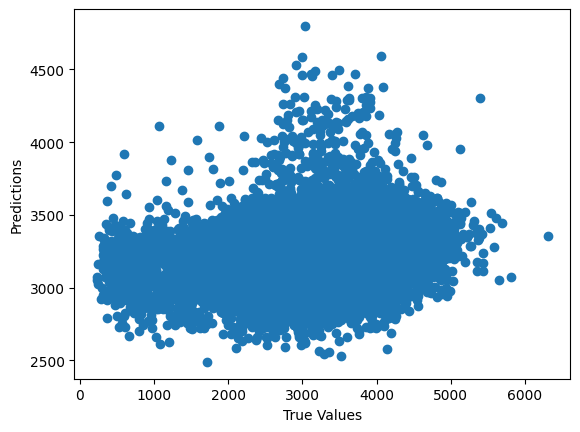

In [88]:
import matplotlib.pyplot as plt

plt.scatter(y_validation, y_validation_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


In [89]:
train_std = np.std(y_train)
train_std

587.5030059550135

In [90]:
predictions = y_validation.to_frame(name="y_true") # the "ground truth" column
mean = model.predict(X_validation)
predictions["pi_lower"] = mean - 2 * train_std
predictions["pi_upper"] = mean + 2 * train_std

# take a quick look
predictions

,y_true,pi_lower,pi_upper
id,,,
33498,3033,2069.842700,4419.854724
7125,3470,2133.230455,4483.242479
8648,2270,2026.048864,4376.060888
74876,3515,2148.358692,4498.370716
12576,3455,1884.794166,4234.806190
...,...,...,...
60199,3208,2194.568254,4544.580278
59559,3410,2135.170759,4485.182783
30715,3969,2152.895318,4502.907342


In [91]:
alpha = 0.1 # the competition alpha
MWIS,coverage = score(predictions["y_true"],predictions["pi_lower"],predictions["pi_upper"],alpha)

print(f"Local MWI score      ",round(MWIS,3))
print("Predictions coverage   ", round(coverage*100,1),"%")

Local MWI score       2760.176
Predictions coverage    95.6 %


In [92]:
cov = []
for j in np.arange(0.5,3,0.25):
  #Prediction
  predictions = y_validation.to_frame(name="y_true") # the "ground truth" column
  mean = model.predict(X_validation)
  predictions["pi_lower"] = mean - j * train_std
  predictions["pi_upper"] = mean + j * train_std

  alpha = 0.1 # the competition alpha
  MWIS,coverage = score(predictions["y_true"],predictions["pi_lower"],predictions["pi_upper"],alpha)
  cov.append(coverage)
  print(f"Number of neighbors ", j)
  print(f"The value of      ",round(MWIS,3))
  print("Predictions coverage   ", round(coverage*100,1),"%")

Number of neighbors  0.5
The value of       4526.114
Predictions coverage    46.2 %
Number of neighbors  0.75
The value of       3503.074
Predictions coverage    63.6 %
Number of neighbors  1.0
The value of       2923.638
Predictions coverage    76.1 %
Number of neighbors  1.25
The value of       2646.312
Predictions coverage    84.5 %
Number of neighbors  1.5
The value of       2570.244
Predictions coverage    90.0 %
Number of neighbors  1.75
The value of       2625.972
Predictions coverage    93.5 %
Number of neighbors  2.0
The value of       2760.176
Predictions coverage    95.6 %
Number of neighbors  2.25
The value of       2944.603
Predictions coverage    96.9 %
Number of neighbors  2.5
The value of       3161.236
Predictions coverage    97.8 %
Number of neighbors  2.75
The value of       3398.413
Predictions coverage    98.3 %


In [93]:
y_pred = model.predict(X_test[selected_features])
test["pi_lower"] = y_pred - 1.5 * train_std
test["pi_upper"] = y_pred + 1.5 * train_std

In [94]:
res = test[["pi_lower","pi_upper"]]

In [95]:
res.head()

,pi_lower,pi_upper
id,,
108082,2430.372717,4192.881735
108083,2312.017556,4074.526574
108084,2192.241833,3954.750851
108085,2313.821807,4076.330825
108086,2324.934759,4087.443777


In [96]:
res.to_csv('submission_tuan_3')
# res.to_csv(submission)